## Mini Project 1 – Banking Campaign Output Prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import models, utils, layers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import SMOTE

In [3]:
data_url = "https://raw.githubusercontent.com/HenokZegeye/BankingCampaignOutputPrediction/main/bank-additional-full.csv"
df = pd.read_csv(data_url, sep=';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset contains 41188 rows and 21 columns.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Data Preprocessing

In [7]:
# The columns are divided into categorical and numerical
categorical_cols = list(df.drop('y', axis=1).select_dtypes(['object']).columns)
numerical_cols = list(df.drop('duration', axis=1).select_dtypes(include=np.number).columns)

Although, there is no explicitly null values, some of the categorical columns contain 'unknown' values. This unknown values don't help the network to learn

In [8]:
df[categorical_cols].isin(['unknown']).sum(axis=0)

job             330
marital          80
education      1731
default        8597
housing         990
loan            990
contact           0
month             0
day_of_week       0
poutcome          0
dtype: int64

In [9]:
df2 = df.apply(lambda x: x.replace('unknown', x.mode()[0]))

Replacing the unknown values with the most frequently appeared values

In [10]:
df_cat = df2[categorical_cols]

In [11]:
df_cat.describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10752,25008,13899,41185,22566,34940,26144,13769,8623,35563


### Convert the categorical features of the dataset into numeric representation using OneHotEncoding

In [12]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(df_cat)
df_cat_encoded = pd.DataFrame(encoder.transform(df_cat), columns=encoder.get_feature_names_out())
df_cat_encoded.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


###Apply scaling for all the numeric features

In [13]:
df_numeric = df2[numerical_cols]

In [14]:
scaler = StandardScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numerical_cols)
df_numeric_scaled.head()
df_numeric_scaled.isnull().sum()

age               0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64

In [15]:
# Assign the feature data to X
X = pd.concat([df_cat_encoded, df_numeric_scaled], axis=1)
X.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_success,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.628993,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,-0.290186,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.002309,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168


Explore the class column of the dataset

In [16]:
# Assign the class data to Y and Convert it to numerical values
Y = df2['y'].apply(lambda x: 1 if x=='yes' else 0)
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

Divide the dataset into Training and Testing set

In [17]:
# Split the data into Training and Testing
# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [18]:
print(f"Training dataset contains {X_train.shape[0]} rows and {X_train.shape[1]} columns.")
print(f"Testing dataset contains {X_test.shape[0]} rows and {X_test.shape[1]} columns.")

Training dataset contains 32950 rows and 56 columns.
Testing dataset contains 8238 rows and 56 columns.


Show The class distribution of the class variable on the training data using bar chart

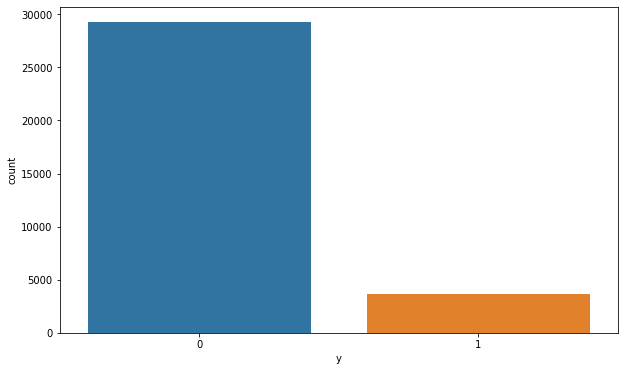

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(data=pd.DataFrame(y_train), x='y')

### Building The Neural Network
##### Three Layer Neural Network(Two Hidden Layers)

In [29]:
network = models.Sequential()
network.add(layers.Dense(units=20, activation="relu", input_shape=(X_train.shape[1],)))
network.add(layers.Dropout(0.25))
network.add(layers.Dense(units=10, activation="relu"))
network.add(layers.Dense(units=1, activation="sigmoid"))

network.compile(optimizer="adam", loss="binary_crossentropy",metrics=['accuracy'])

network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                1140      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Train the network
callbacks = [EarlyStopping(monitor="val_loss", patience=2),
ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]
history=network.fit(X_train, y_train,epochs=20, validation_data=(X_test,y_test), callbacks=callbacks, batch_size=8, verbose=1)

Epoch 1/20
4119/4119 [==============================] - 11s 2ms/step - loss: 0.2946 - accuracy: 0.8941 - val_loss: 0.2780 - val_accuracy: 0.8989
Epoch 2/20
4119/4119 [==============================] - 9s 2ms/step - loss: 0.2826 - accuracy: 0.8985 - val_loss: 0.2777 - val_accuracy: 0.8989
Epoch 3/20
4119/4119 [==============================] - 9s 2ms/step - loss: 0.2797 - accuracy: 0.9003 - val_loss: 0.2765 - val_accuracy: 0.8997
Epoch 4/20
4119/4119 [==============================] - 10s 2ms/step - loss: 0.2788 - accuracy: 0.8999 - val_loss: 0.2768 - val_accuracy: 0.8997
Epoch 5/20
4119/4119 [==============================] - 9s 2ms/step - loss: 0.2765 - accuracy: 0.9008 - val_loss: 0.2788 - val_accuracy: 0.8996


In [31]:
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
epoch_count = range(1, len(training_loss) + 1)

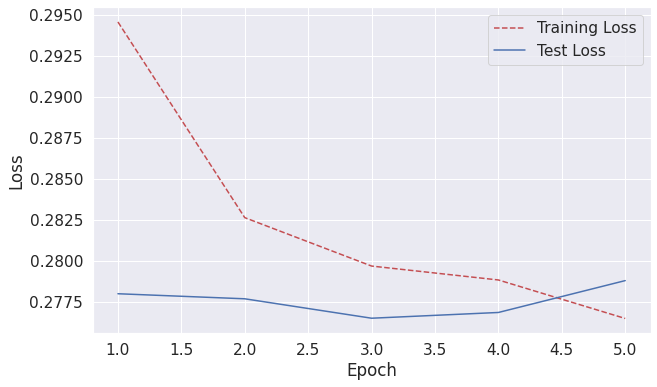

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [33]:
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

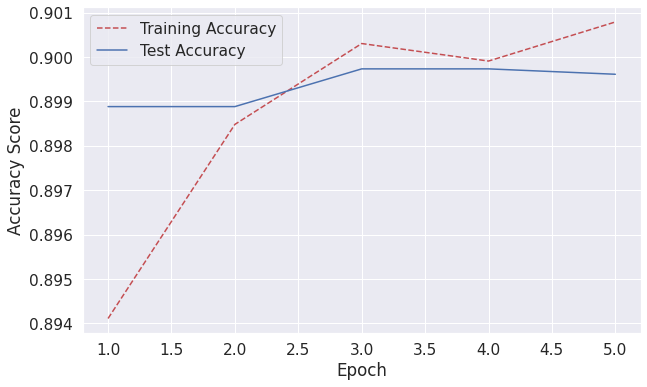

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show()

### Model Performance

In [35]:
y_pred = (network.predict(X_test)).round().astype("int32")
print(classification_report(y_test, y_pred))

258/258 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7294
           1       0.66      0.26      0.37       944

    accuracy                           0.90      8238
   macro avg       0.79      0.62      0.66      8238
weighted avg       0.88      0.90      0.88      8238



In [36]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.3f}%')

Accuracy: 89.961%


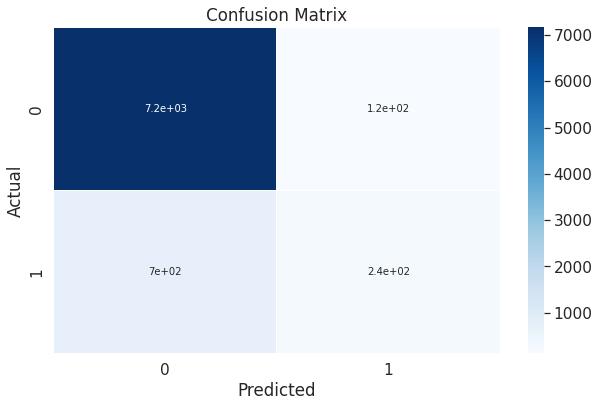

In [37]:
plt.figure(figsize=(10, 6))
conf_mat = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Network Architecture

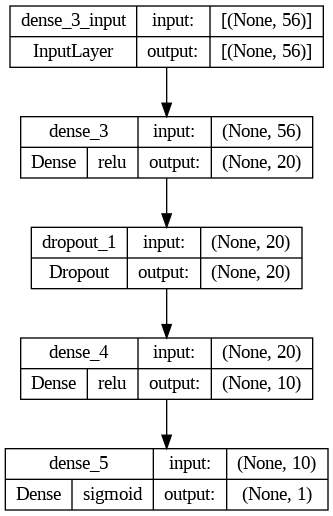

In [38]:
utils.plot_model(
network,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)
